In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing with average daily gas and electricity

- Introduction

(1) Reviewing the raw dataset

- Load "raw dataset", this is based on Eoghan's notebook "household_energy_demand_preprocessing.ipynb". This dataset contains each day's average hourly gas and electricity usage. 

- Analyze this average hourly data against the entire dataset and also by each month. Compare these results with a benchmark. The analysis shows that while electricity usage is within expected limits, gas usage is unusually high and exceeds the benchmark.

(2) Addressing Gas Usage Issues

- Identify and deal with outliers in gas usage.

- Detect and resolve issues with zero and missing (NaN) values in gas usage

- After these corrections, we get a reasonable dataset that contains both gas and electricity data from "raw dataset". Name this dataset "original". save it as "daily_energy_use_after_processing_outliers"






# (1) Reviewing the Raw Dataset

In [203]:
# load raw dataset "daily_demand_and_weather.csv", this dataset is dervied from Eoghan's notebook "household_energy_demand_preprocessing.ipynb".
# this is average hourly energy use in each day of each household, the unit is watt-hour

energy_use = pd.read_csv('../data/daily_demand_and_weather.csv') 
energy_use.head()


,household_id,datetime,maxtemp,mintemp,conditions,day_of_week,is_weekend,is_bank_holiday,mean_rounded_gas_pulse,mean_rounded_electric_combined
0,100,2017-03-07,10.0,4.0,Chance of Rain,1.0,False,False,5277.0,343.0
1,100,2017-03-08,11.0,5.0,Chance of Rain,2.0,False,False,6832.0,253.0
2,100,2017-03-09,11.0,3.0,Chance of Rain,3.0,False,False,1283.0,203.0
3,100,2017-03-10,10.0,7.0,Overcast,4.0,False,False,4168.0,222.0
4,100,2017-03-11,13.0,6.0,Chance of Rain,5.0,True,False,1264.0,243.0


In [204]:
# generate some columns related to time for furthur use
energy_use['datetime'] = pd.to_datetime(energy_use['datetime'])
energy_use['year'] = pd.to_datetime(energy_use['datetime']).dt.year
energy_use['month'] = pd.to_datetime(energy_use['datetime']).dt.month
energy_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71606 entries, 0 to 71605
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   household_id                    71606 non-null  int64         
 1   datetime                        71606 non-null  datetime64[ns]
 2   maxtemp                         59439 non-null  float64       
 3   mintemp                         59439 non-null  float64       
 4   conditions                      59439 non-null  object        
 5   day_of_week                     59439 non-null  float64       
 6   is_weekend                      59439 non-null  object        
 7   is_bank_holiday                 59439 non-null  object        
 8   mean_rounded_gas_pulse          59841 non-null  float64       
 9   mean_rounded_electric_combined  66661 non-null  float64       
 10  year                            71606 non-null  int32         
 11  mo

In [205]:
# have a look at the distribution of the energy consumption
energy_use[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].describe()

,mean_rounded_gas_pulse,mean_rounded_electric_combined
count,5.984100e+04,66661.000000
mean,5.129364e+03,372.756754
std,2.723895e+04,228.590686
min,-7.467000e+03,0.000000
25%,1.331000e+03,215.000000
50%,2.868000e+03,327.000000
75%,5.150000e+03,476.000000
max,3.285736e+06,5025.000000


The unit of measurement is watt-hours, representing the average hourly usage for each day. 

At first impression, the electricity values appear normal, with a minimum of 0, a maximum of 5025, and a median of 327. 

However, the gas values are unusual: the minimum is below 0, which is not possible, and the maximum is extremely high at 3.28*10^6. the mean of hourly gas in a day is over 5000 watt-hour, which is also strange. so we should deal with outliers.

# Compare raw dataset's mean and medain value with a benchmark. 

Benchmark (same unit): 

- Average Energy Use Scottland https://great-home.co.uk/average-energy-consumption-calculator-scotland/ 

mean gas: 1626 watt-hours. (14,400 kWh a year).

mean electricity is: 375 watt-hours, (3,200 kWh a year).

- Result from BEIS's report on 2017 metered energy consumption show that: 

 median gas: 1404 watt-hours, (12,300 kWh/year).

 median gas: 354 watt-hours, (3100 kWh/year).

 https://assets.publishing.service.gov.uk/media/61449c45e90e07044435c9e7/efus-Household-Energy-Consumption-Affordability.pdf


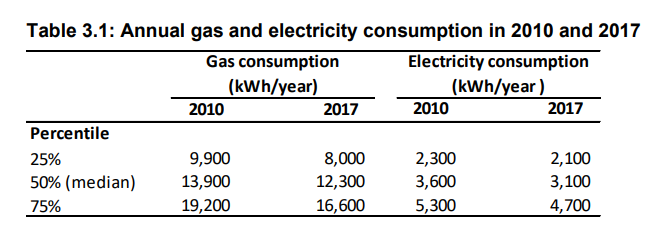

- Comparsion

the results of mean gas of entire dataset (5129 watt-hours) which is odd and much higher than benchmark (1626 watt-hours). the median value 2868 watt-hours ia also higher than benchmark (1404 watt-hours).

the result of mean electricity of entire dataset (372 watt-hours) is close to bechmark (375 watt-hours). the median value 327 watt-hours ia also close to benchmark (354 watt-hours). this seems to be reasonable.

- We see only gas value is odd, so we need to deal with it

# (2) Addressing Gas Usage Issues

Before addressing the issues with gas usage in the "energy use" dataset, we will make a copy of it and name this copy "original." 

This step ensures that the electricity data remains unaffected by the processes we apply to the gas usage data. 

After resolving the issues with gas data in the "energy use" dataset and obtaining reasonable gas data, we will use the "original" dataset again.

In [207]:
original = energy_use.copy() # take a copy 

# Detect the outliers of gas use

<Axes: >

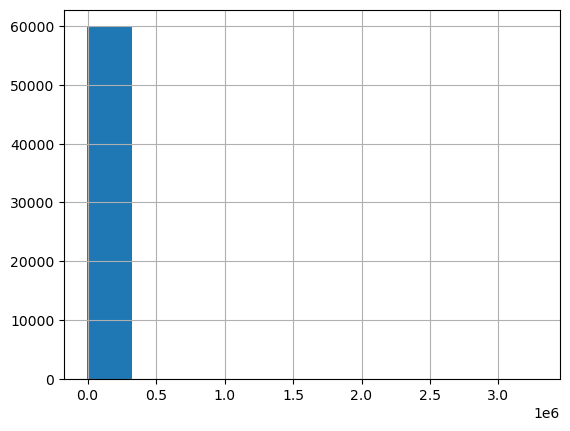

In [208]:
# continue deal with gas data on dataset "energy_use"

# check the distribution of gas_pulse
energy_use['mean_rounded_gas_pulse'].hist()

We've identified extremely obvious outliers in the gas usage data; for example, an average hourly gas consumption nearly 60,000 watt-hours in a day is impossible. 

We assume that by addressing these outliers, the average gas usage should align more closely with the benchmark values.

# Deal with extreme outliers

- We need to identify extremely high outliers in our gas usage data.
- It's important to account for winter conditions, where gas consumption can be significantly higher. Any daily values that exceed the highest average hourly gas use recorded in winter will be considered as extreme outliers.
- According to a 2017 BEIS report on energy consumption, daily gas usage varied widely during the EFUS heating season, ranging from 27 kWh/day in October to 64 kWh/day in January. This variation reflects the seasonal changes in gas usage.
- Based on this, we've set a threshold where daily gas usage should not exceed 64 kWh, equal to 6400 watt-hours.


Thus, any value exceeding 6400 will be classified as 'extreme_outliers'.

In [209]:
# when the value is higher than 6400, we set this value to be 'extreme_outliers'
energy_use['mean_rounded_gas_pulse'] = energy_use['mean_rounded_gas_pulse'].apply(lambda x: 'extreme_outliers' if x > 6400 else x )

# remove the rows with 'extreme_outliers', in order to not affect any other data (e.g. not affect exsited NaN)
energy_use = energy_use[energy_use['mean_rounded_gas_pulse'] != 'extreme_outliers']

- Setting Negative Values to Zero

This is a sensible approach as negative values for gas consumption are not possible and likely result from data entry errors or sensor malfunctions.

In [210]:
# check number of of negetive values
zero_gas_count = (energy_use['mean_rounded_gas_pulse'] < 0).sum()
print("Number of zero gas values:", zero_gas_count)

print('set negetive value to be 0')
energy_use['mean_rounded_gas_pulse'] = energy_use['mean_rounded_gas_pulse'].clip(lower=0)

Number of zero gas values: 1
set negetive value to be 0


# Check the results after remove extremly outliers of gas useage

In [211]:
# distribution of gas use after deal with outliers
energy_use[['mean_rounded_gas_pulse']].astype(float).describe()

,mean_rounded_gas_pulse
count,49468.000000
mean,2548.806845
std,1666.599693
min,0.000000
25%,1106.000000
50%,2291.000000
75%,3769.000000
max,6399.000000


- the results of mean gas of entire dataset (2548 watt-hours) which become more "reasonable" but still higher than benchmark (1626 watt-hours). the median value 2291 watt-hours ia also higher than benchmark (1404 watt-hours).

To further refine the data, we need to consider the instances where homes did not use gas on a particular day.

Previously, we assumed that values below 0 indicated no gas usage, and we adjusted them to 0. 

However, we must also consider how to handle NaN values. It's possible that NaN values represent days when gas was not used, and the sensors failed to record any data. (will validate the results by comparing medain value with benchmark)

Therefore, we need to investigate the NaN values in the gas data to determine their significance and adjust accordingly.

# Deal with NaN value of gas use

- determine the days that residentis did not use gas.

In [212]:
# check the missing gas value of each month in raw dataset
missing_gas = energy_use.copy()
missing_gas = missing_gas.groupby(by=['year','month'])['mean_rounded_gas_pulse'].apply(lambda x: x.isnull().sum())
missing_gas

year  month
2016  8          36
      9          63
      10         45
      11        100
      12        125
2017  1         149
      2         117
      3         135
      4         209
      5         239
      6         400
      7         581
      8         539
      9         736
      10        758
      11        784
      12       1007
2018  1         953
      2         758
      3         920
      4        1072
      5        1203
      6         836
Name: mean_rounded_gas_pulse, dtype: int64

We've observed a significant number of missing values in the daily gas usage data in each month, which could explain why the average gas consumption consistently exceeds the benchmark. 

We have decided to interpret these NaN values as instances where no gas was used on that particular day. 

Therefore, we will set these NaN values to 0 rather than treating them as missing data. This approach should help provide a more accurate reflection of actual gas usage.

In [213]:
# set the missing gas value to 0
energy_use['mean_rounded_gas_pulse'] = energy_use['mean_rounded_gas_pulse'].fillna(0)

In [214]:
energy_use

,household_id,datetime,maxtemp,mintemp,conditions,day_of_week,is_weekend,is_bank_holiday,mean_rounded_gas_pulse,mean_rounded_electric_combined,year,month
0,100,2017-03-07,10.0,4.0,Chance of Rain,1.0,False,False,5277.0,343.0,2017,3
2,100,2017-03-09,11.0,3.0,Chance of Rain,3.0,False,False,1283.0,203.0,2017,3
3,100,2017-03-10,10.0,7.0,Overcast,4.0,False,False,4168.0,222.0,2017,3
4,100,2017-03-11,13.0,6.0,Chance of Rain,5.0,True,False,1264.0,243.0,2017,3
5,100,2017-03-12,11.0,4.0,Clear,6.0,True,False,3855.0,324.0,2017,3
...,...,...,...,...,...,...,...,...,...,...,...,...
71601,99,2018-06-26,16.0,11.0,Partly Cloudy,1.0,False,False,941.0,331.0,2018,6
71602,99,2018-06-27,22.0,12.0,Partly Cloudy,2.0,False,False,907.0,391.0,2018,6
71603,99,2018-06-28,28.0,11.0,Clear,3.0,False,False,702.0,360.0,2018,6
71604,99,2018-06-29,16.0,9.0,Partly Cloudy,4.0,False,False,895.0,500.0,2018,6


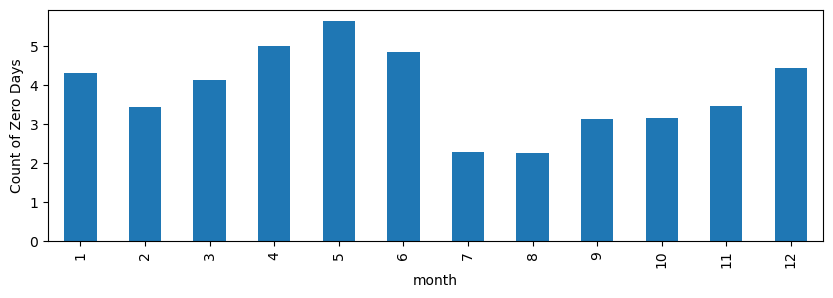

In [215]:
# check how many days that gas is 0 of average home in each month (if the gas is 0, it means the gas is not used in that particular day)
zero_gas  = energy_use[['datetime','mean_rounded_gas_pulse']].copy()
zero_gas = zero_gas[zero_gas['mean_rounded_gas_pulse'] == 0]
zero_gas['month'] = pd.to_datetime(zero_gas['datetime']).dt.month
zero_gas_count = zero_gas.groupby(by=['month']).size() / 255 #  average number of zero gas value of each home in each month
zero_gas_count.plot(kind='bar',figsize=(10, 3))
plt.ylabel('Count of Zero Days')
plt.show()

The results appear reasonable; on average, there may be days in each month when residents do not consume gas, potentially due to being on holiday or for other reasons.

# check gas distrubution after dealing NaN value of gas

In [216]:
# check result of gas
energy_use[['mean_rounded_gas_pulse']].describe()

,mean_rounded_gas_pulse
count,61233.000000
mean,2059.091944
std,1803.403717
min,0.000000
25%,434.000000
50%,1692.000000
75%,3371.000000
max,6399.000000


- the results of mean gas of entire dataset (2059 watt-hours) was decreased eventhough still higher than benchmark (1626 watt-hours). the median value 1629 watt-hours is close to benchmark (1404 watt-hours).

Text(0, 0.5, 'Gas use')

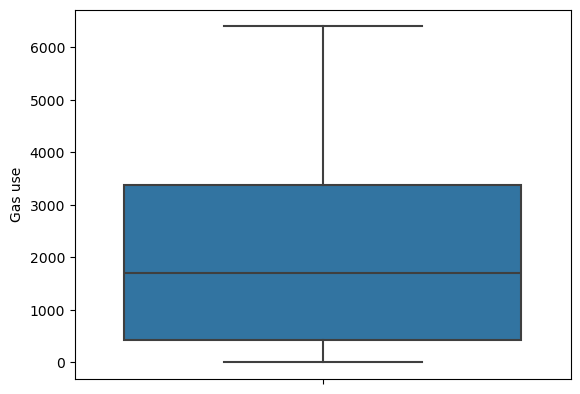

In [217]:
# using boxplot to check whether there are outliers under the principle of 1.5*IQR. Interquartile Range (IQR) Method

sns.boxplot(y=energy_use['mean_rounded_gas_pulse'])
plt.ylabel('Gas use')

- we can see that there are not outliers in gas now.

- In conclusion:

Although the average gas consumption (2,059 watt-hours) remains above the benchmark (1,626 watt-hours), the median value closely aligns with the benchmark. 

Therefore, we will retain these final results of gas.

# Integrate processed gas data back into main dataset

In [218]:
# integrate the column of processed gas data into the main dataset named 'original' which contains original electricity data.
original['mean_rounded_gas_pulse'] = energy_use['mean_rounded_gas_pulse']

In [219]:
# check the final result of "original" dataset
original[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].describe()

,mean_rounded_gas_pulse,mean_rounded_electric_combined
count,61233.000000,66661.000000
mean,2059.091944,372.756754
std,1803.403717,228.590686
min,0.000000,0.000000
25%,434.000000,215.000000
50%,1692.000000,327.000000
75%,3371.000000,476.000000
max,6399.000000,5025.000000


<Axes: xlabel='month'>

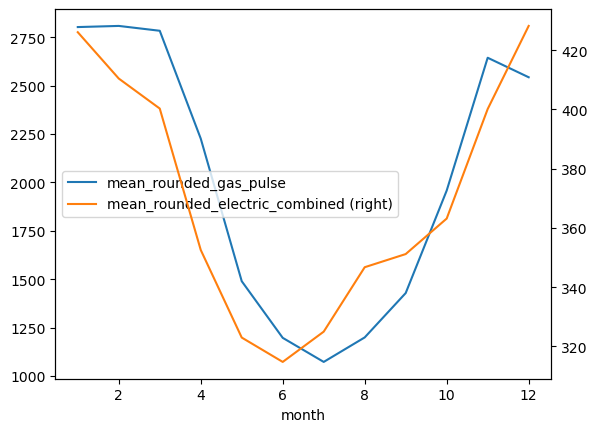

In [220]:
# check value of each month
monthly_energy = original.copy().groupby(by=['month'])[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].mean()
monthly_energy.plot(secondary_y='mean_rounded_electric_combined')

In [221]:
# rename the column name of "household_id" to "homeid" for furthur use
original.rename(columns={'household_id':'homeid'}, inplace=True)
original

,homeid,datetime,maxtemp,mintemp,conditions,day_of_week,is_weekend,is_bank_holiday,mean_rounded_gas_pulse,mean_rounded_electric_combined,year,month
0,100,2017-03-07,10.0,4.0,Chance of Rain,1.0,False,False,5277.0,343.0,2017,3
1,100,2017-03-08,11.0,5.0,Chance of Rain,2.0,False,False,NaN,253.0,2017,3
2,100,2017-03-09,11.0,3.0,Chance of Rain,3.0,False,False,1283.0,203.0,2017,3
3,100,2017-03-10,10.0,7.0,Overcast,4.0,False,False,4168.0,222.0,2017,3
4,100,2017-03-11,13.0,6.0,Chance of Rain,5.0,True,False,1264.0,243.0,2017,3
...,...,...,...,...,...,...,...,...,...,...,...,...
71601,99,2018-06-26,16.0,11.0,Partly Cloudy,1.0,False,False,941.0,331.0,2018,6
71602,99,2018-06-27,22.0,12.0,Partly Cloudy,2.0,False,False,907.0,391.0,2018,6
71603,99,2018-06-28,28.0,11.0,Clear,3.0,False,False,702.0,360.0,2018,6
71604,99,2018-06-29,16.0,9.0,Partly Cloudy,4.0,False,False,895.0,500.0,2018,6


Now, we have successfully completed the preprocessing of the raw gas and electricity data. Save the this dataset after deal with outliers to furthur use.

In [222]:
# save the final dataset
# original.to_csv('daily_energy_use_after_processing_outliers.csv', index=False)